# Scenario 3 subtask 1: Estimate the True Number of Infections

# Clean Version

**Background:** 10/2020 - 1/2021 in Greater Boston area. Predicting cases from wastewater potentially reports closer to the truth than testing.

## **TASK 1:** Replicate the fitting exercise (A) in Section 3.2 <br>
paper: https://doi.org/10.1016/j.scitotenv.2022.159326.

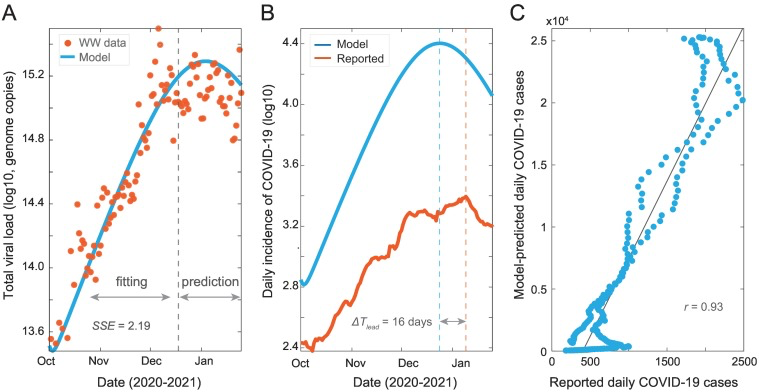

**Specifications:**
1. SEIR-V model
2. Fit $\lambda$, $\alpha$, and E(0).
3. Data found in supplementary materials
4. Simplify wherever necessary (e.g. fixed $\beta$)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyciemss.visuals.plots as plots
from pyciemss.PetriNetODE.interfaces import (
    load_and_sample_petri_model,
    load_and_calibrate_and_sample_petri_model,
    load_petri_model,
    setup_petri_model,
    sample
)
from pyciemss.utils.interface_utils import convert_to_output_format
from pyciemss.utils import get_tspan

from mira.sources.askenet.petrinet import model_from_url
from mira.metamodel import Distribution
from mira.modeling.askenet.petrinet import AskeNetPetriNetModel
from mira.modeling import Model
import urllib.request, json
import requests

### Plot the Data:

,V
time,
0,3.424864e+13
1,7.482611e+13
2,1.107730e+14
3,1.455132e+14
4,1.789461e+14
...,...
221,1.256720e+17
222,1.257698e+17
223,1.258096e+17


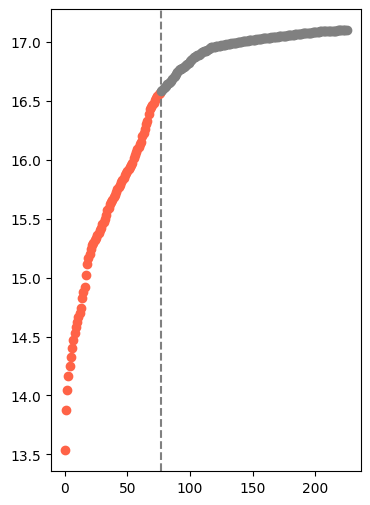

In [2]:
# Load Data
## This uses the cumsum() of the raw data
data_train = pd.read_csv('./data/processed_dataset_train.csv', index_col="time")
data_test  = pd.read_csv('./data/processed_dataset_test.csv', index_col="time")
data_whole = pd.read_csv('./data/processed_dataset.csv', index_col="time")
display(data_whole)

# Plot
plt.figure(figsize=(4,6))
plt.scatter(data_train.index, np.log10(data_train.V), color='tomato')
plt.scatter(data_test.index, np.log10(data_test.V), color='grey')
plt.axvline(77, linestyle='dashed', color='grey')

### Simulate using the best fit parameters

$\beta = 4.49\times 10^7$ viral RNA per g.

Best fit parameters: $\lambda =9.66\times 10^{-8}\frac{1}{day\cdot person}, \alpha = 249 g, \gamma = 0.08, \text{ and } E(0) = 11 \text{ people.}$



In [4]:
from mira.sources.askenet import model_from_json_file


best_fit_model = model_from_json_file('ES3_detection_log10V.json')
best_fit_model.initials['E'].value = 11
S, E, I = best_fit_model.initials['S'].value, best_fit_model.initials['E'].value, best_fit_model.initials['I'].value

best_fit_model.parameters['lambda'].value = 9.66e-8*(S + E + I)
#best_fit_model.parameters['lambda'].distribution = Distribution(type="Uniform1", parameters={"minimum": 0.2, "maximum":0.21})
best_fit_model.parameters['gamma'].value = 0.08
best_fit_model.parameters['beta'].value = 44852600
best_fit_model.parameters['delta'].value = 0.125

best_fit_model.parameters['k'].value = 0.333
#best_fit_model.parameters['k'].distribution = Distribution(type="Uniform1", parameters={"minimum": 0.25, "maximum":0.5})

best_fit_model.parameters['alpha'].value = 249 
best_fit_model.parameters['alpha'].distribution = None#distribution=Distribution(type='Uniform1', parameters={'minimum': 50.0, 'maximum': 400.0})

In [5]:
best_fit_model.parameters

{'lambda': Parameter(name='lambda', display_name=None, description=None, identifiers={}, context={}, units=Unit(expression=1/(day*person)), value=0.2221810626, distribution=None),
 'k': Parameter(name='k', display_name=None, description=None, identifiers={}, context={}, units=None, value=0.333, distribution=None),
 'delta': Parameter(name='delta', display_name=None, description=None, identifiers={}, context={}, units=Unit(expression=1/day), value=0.125, distribution=None),
 'alpha': Parameter(name='alpha', display_name=None, description=None, identifiers={}, context={}, units=Unit(expression=gram), value=249, distribution=None),
 'beta': Parameter(name='beta', display_name=None, description=None, identifiers={}, context={}, units=Unit(expression=virus/gram), value=44852600, distribution=None),
 'gamma': Parameter(name='gamma', display_name=None, description=None, identifiers={}, context={}, units=Unit(expression=1/day), value=0.08, distribution=None)}

In [6]:
num_samples = 1
start_time = 0
end_time = 226 # between 10/02/2020 and 01/25/2021
num_timepoints = (end_time-start_time)*10 + 1
timepoints = list(get_tspan(start_time, end_time, num_timepoints).detach().numpy())

prior_samples = load_and_sample_petri_model(
        best_fit_model, num_samples, timepoints=timepoints,
    visual_options={"title": "3_base", "keep":["V_sol"]}, time_unit="days")
prior_samples['data']

,timepoint_id,sample_id,lambda_param,k_param,delta_param,alpha_param,beta_param,gamma_param,C_sol,D_sol,E_sol,I_sol,S_sol,U_sol,V_sol,logV_obs,timepoint_days
0,0,0,0.222181,0.333,0.125,249.0,44852600.0,0.08,4.069259e-21,1.355063e-21,11.000000,3.663000e-10,2.300000e+06,2.714195e-21,3.424865e+13,13.534644,0.000000
1,1,0,0.222181,0.333,0.125,249.0,44852600.0,0.08,4.007915e-03,1.334636e-03,10.643693,3.580576e-01,2.300000e+06,2.673279e-03,3.424883e+13,13.534646,0.100000
2,2,0,0.222181,0.333,0.125,249.0,44852600.0,0.08,1.579279e-02,5.258999e-03,10.306707,7.001994e-01,2.300000e+06,1.053379e-02,3.424937e+13,13.534653,0.200000
3,3,0,0.222181,0.333,0.125,249.0,44852600.0,0.08,3.501020e-02,1.165839e-02,9.988067,1.027246e+00,2.300000e+06,2.335180e-02,3.425027e+13,13.534664,0.300000
4,4,0,0.222181,0.333,0.125,249.0,44852600.0,0.08,6.133348e-02,2.042405e-02,9.686850,1.339977e+00,2.300000e+06,4.090944e-02,3.425148e+13,13.534680,0.400000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2256,2256,0,0.222181,0.333,0.125,249.0,44852600.0,0.08,2.291152e+06,7.629524e+05,8876.043945,8.300092e+04,8.849312e+03,1.528197e+06,1.808123e+17,17.257228,225.600006
2257,2257,0,0.222181,0.333,0.125,249.0,44852600.0,0.08,2.291312e+06,7.630054e+05,8743.347656,8.226141e+04,8.688673e+03,1.528304e+06,1.808971e+17,17.257432,225.699997
2258,2258,0,0.222181,0.333,0.125,249.0,44852600.0,0.08,2.291470e+06,7.630576e+05,8612.319336,8.152660e+04,8.530710e+03,1.528409e+06,1.809811e+17,17.257634,225.800003
2259,2259,0,0.222181,0.333,0.125,249.0,44852600.0,0.08,2.291624e+06,7.631109e+05,8482.977539,8.079698e+04,8.375464e+03,1.528513e+06,1.810649e+17,17.257835,225.899994


# Plot the uncalibrated trajectories

In [7]:
schema = plots.trajectories(pd.DataFrame(prior_samples["data"]), keep=["V_sol"],
                            markers={"Training": 77},
                           points=data_whole.reset_index(drop=True).rename(columns={"V":"V_data"})
                           )
schema = plots.pad(schema, 5)
plots.ipy_display(schema)

ERROR TypeError: Cannot read properties of null (reading 'getContext')
    at ct (https://cdn.skypack.dev/-/vega-label@v1.2.1-hEHqe293fM7lKP2OHb0o/dist=es2020,mode=imports,min/optimized/vega-label.js:1:777)
    at Ot (https://cdn.skypack.dev/-/vega-label@v1.2.1-hEHqe293fM7lKP2OHb0o/dist=es2020,mode=imports,min/optimized/vega-label.js:1:7314)
    at et.transform (https://cdn.skypack.dev/-/vega-label@v1.2.1-hEHqe293fM7lKP2OHb0o/dist=es2020,mode=imports,min/optimized/vega-label.js:1:9086)
    at et.evaluate (https://cdn.skypack.dev/-/vega-dataflow@v5.7.5-asKYS4gpPLMPf64pSozt/dist=es2020,mode=imports,min/optimized/vega-dataflow.js:1:15429)
    at et.run (https://cdn.skypack.dev/-/vega-dataflow@v5.7.5-asKYS4gpPLMPf64pSozt/dist=es2020,mode=imports,min/optimized/vega-dataflow.js:1:15286)
    at ne.Gt [as evaluate] (https://cdn.skypack.dev/-/vega-dataflow@v5.7.5-asKYS4gpPLMPf64pSozt/dist=es2020,mode=imports,min/optimized/vega-dataflow.js:1:12073)
    at ne.evaluate (https://cdn.skypack.dev/-/v

ValueError: Vega to SVG conversion failed:
Err(Any { .. })

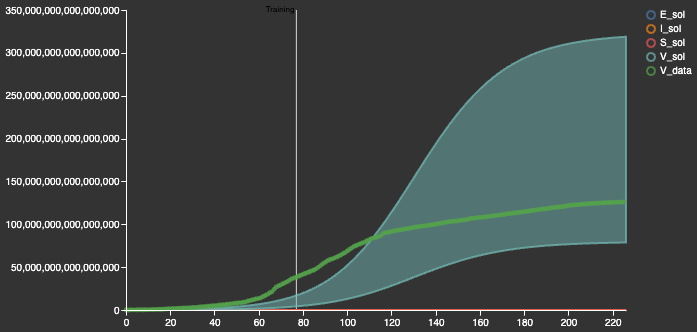

### Calibrate:

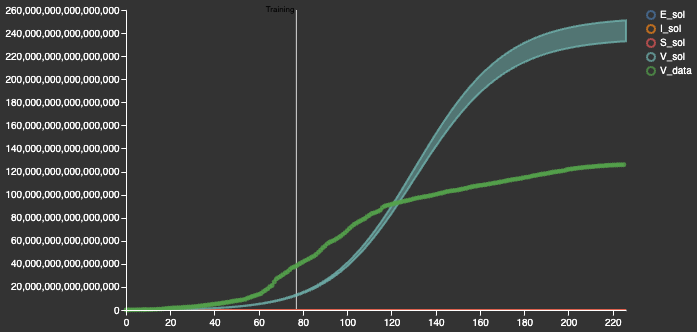

### Mimic the paper figure

In [ ]:
# TODO

## **TASK 3:** Repeat with uncertainty over the paper's parameters.

In [8]:
#SEIV_model_url  = "https://raw.githubusercontent.com/indralab/mira/hackathon2/notebooks/evaluation_2023.07/eval_scenario3_base.json"
from mira.sources.askenet import model_from_json_file
SEIVCDU_model_json = 'ES3_detection_log10V.json'
uncertain_model = model_from_json_file('ES3_detection_log10V.json')
uncertain_model.initials['E'].value = 1000
S, E, I = uncertain_model.initials['S'].value, uncertain_model.initials['E'].value, uncertain_model.initials['I'].value

uncertain_model.parameters['lambda'].value = 9.66e-8*(S + E + I)
uncertain_model.parameters['lambda'].distribution = Distribution(type="Uniform1", parameters={"minimum": 0.1, "maximum":0.21})
uncertain_model.parameters['gamma'].value = 0.08
uncertain_model.parameters['gamma'].distribution = Distribution(type="Uniform1", parameters={"minimum": 0.05, "maximum":0.15})
uncertain_model.parameters['beta'].value = 44852600
uncertain_model.parameters['delta'].value = 0.125

uncertain_model.parameters['k'].value = 0.333
uncertain_model.parameters['k'].distribution = Distribution(type="Uniform1", parameters={"minimum": 0.25, "maximum":0.5})

uncertain_model.parameters['alpha'].value = 249 
uncertain_model.parameters['alpha'].distribution = distribution=Distribution(type='Uniform1', parameters={'minimum': 50.0, 'maximum': 400.0})

In [9]:
num_samples = 100
start_time = 0
end_time = 226 # between 10/02/2020 and 01/25/2021
num_timepoints = (end_time-start_time)*10 + 1
timepoints = list(get_tspan(start_time, end_time, num_timepoints).detach().numpy())

prior_samples = load_and_sample_petri_model(
        uncertain_model, num_samples, timepoints=timepoints,
    visual_options={"title": "3_base", "keep":["V_sol"]}, time_unit="days")

In [10]:
prior_samples['data']

,timepoint_id,sample_id,lambda_param,k_param,alpha_param,gamma_param,delta_param,beta_param,C_sol,D_sol,E_sol,I_sol,S_sol,U_sol,V_sol,logV_obs,timepoint_days
0,0,0,0.156348,0.412212,256.325867,0.072559,0.125,44852600.0,3.221017e-19,1.327742e-19,1000.000000,4.122120e-08,2.300000e+06,1.893275e-19,3.424865e+13,13.534644,0.000000
1,1,0,0.156348,0.412212,256.325867,0.072559,0.125,44852600.0,3.164138e-01,1.304296e-01,959.928955,4.013440e+01,2.300000e+06,1.859843e-01,3.427023e+13,13.534917,0.100000
2,2,0,0.156348,0.412212,256.325867,0.072559,0.125,44852600.0,1.243530e+00,5.125980e-01,922.074219,7.817464e+01,2.299999e+06,7.309321e-01,3.433348e+13,13.535718,0.200000
3,3,0,0.156348,0.412212,256.325867,0.072559,0.125,44852600.0,2.749522e+00,1.133386e+00,886.315186,1.142351e+02,2.299997e+06,1.616137e+00,3.443624e+13,13.537016,0.300000
4,4,0,0.156348,0.412212,256.325867,0.072559,0.125,44852600.0,4.804303e+00,1.980391e+00,852.537903,1.484238e+02,2.299995e+06,2.823912e+00,3.457643e+13,13.538780,0.400000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226095,2256,99,0.166177,0.400594,279.396729,0.128789,0.125,44852600.0,1.627918e+06,6.521334e+05,56883.851562,1.830603e+05,6.720822e+05,9.757844e+05,1.213497e+17,17.084039,225.600006
226096,2257,99,0.166177,0.400594,279.396729,0.128789,0.125,44852600.0,1.630158e+06,6.530310e+05,56846.605469,1.830501e+05,6.698416e+05,9.771274e+05,1.215495e+17,17.084754,225.699997
226097,2258,99,0.166177,0.400594,279.396729,0.128789,0.125,44852600.0,1.632397e+06,6.539279e+05,56808.859375,1.830385e+05,6.676024e+05,9.784694e+05,1.217494e+17,17.085467,225.800003
226098,2259,99,0.166177,0.400594,279.396729,0.128789,0.125,44852600.0,1.634633e+06,6.548239e+05,56770.636719,1.830256e+05,6.653657e+05,9.798101e+05,1.219492e+17,17.086179,225.899994


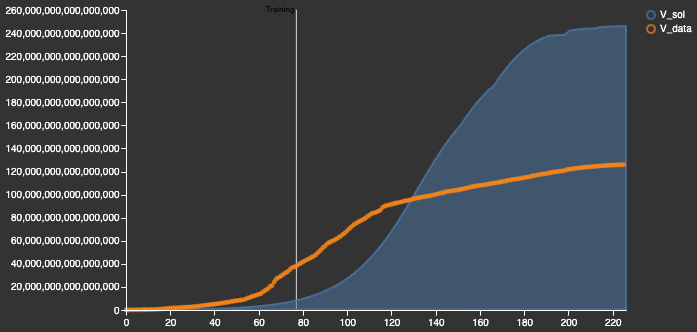

In [11]:
schema = plots.trajectories(pd.DataFrame(prior_samples["data"]), keep="V_sol",
                            markers={"Training": 77},
                            points=data_whole.reset_index(drop=True).rename(columns={"V":"V_data"}))
schema = plots.pad(schema, 5)
plots.ipy_display(schema)

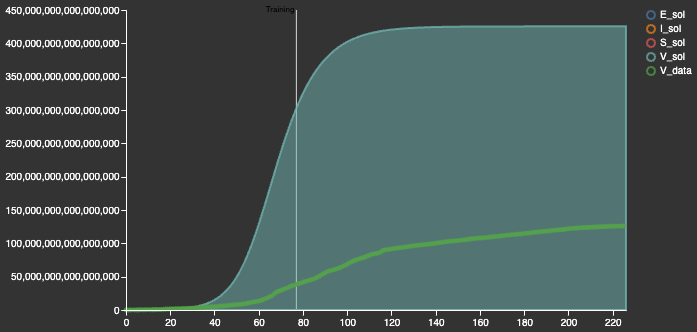

### Calibrate:

In [12]:
calibrated_samples = load_and_calibrate_and_sample_petri_model(
            uncertain_model,
            './data/processed_dataset_train.csv',
            100,
            timepoints=timepoints,
            num_iterations=200,
            verbose=True,
            visual_options={"title": "3_base", "keep":["V_sol"]}, time_unit="days")

/Users/zuck016/Projects/Proposals/ASKEM/build/clean-build/src/pyciemss/PetriNetODE/interfaces.py:864: UserWarning: Observation ObservationEvent(time=1.0000088214874268, observation={'V': tensor(7.4826e+13)}) is not in the range [0, 34248648032256.0]. This may be an error!
  warnings.warn(f"Observation {obs} is not in the range [0, {petri.total_population}]. This may be an error!")
/Users/zuck016/Projects/Proposals/ASKEM/build/clean-build/src/pyciemss/PetriNetODE/interfaces.py:864: UserWarning: Observation ObservationEvent(time=2.0000009536743164, observation={'V': tensor(1.1077e+14)}) is not in the range [0, 34248648032256.0]. This may be an error!
  warnings.warn(f"Observation {obs} is not in the range [0, {petri.total_population}]. This may be an error!")
/Users/zuck016/Projects/Proposals/ASKEM/build/clean-build/src/pyciemss/PetriNetODE/interfaces.py:864: UserWarning: Observation ObservationEvent(time=3.000009775161743, observation={'V': tensor(1.4551e+14)}) is not in the range [0, 3

iteration 0: loss = 540429.1468148232
iteration 25: loss = 122591.59143328667
iteration 50: loss = 69645.5154736042
iteration 75: loss = 53010.61304116249
iteration 100: loss = 44186.46819067001
iteration 125: loss = 35503.64799976349
iteration 150: loss = 32004.087381124496
iteration 175: loss = 29485.084490776062


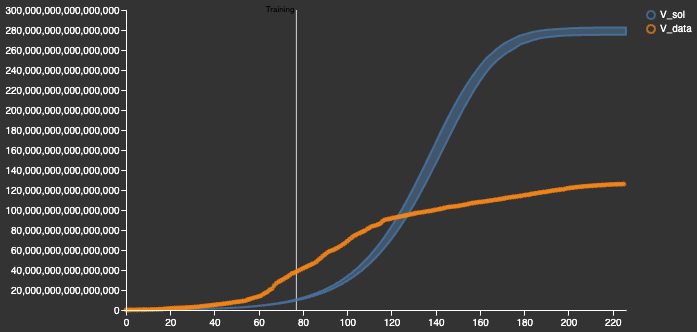

In [13]:
schema = plots.trajectories(pd.DataFrame(calibrated_samples["data"]), keep="V_sol",
                            markers={"Training": 77},
                            points=data_whole.reset_index(drop=True).rename(columns={"V":"V_data"}))
schema = plots.pad(schema, 5)
plots.ipy_display(schema)

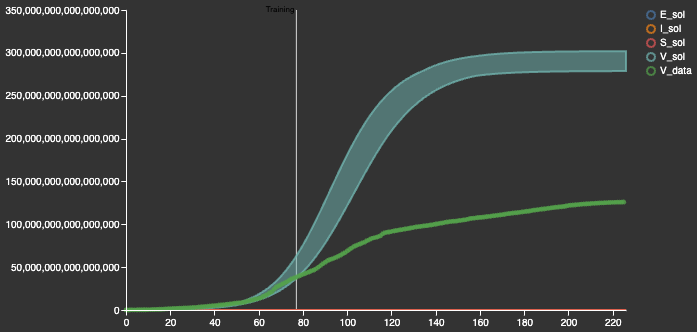

In [14]:
# View what values the calibration landed on
display(calibrated_samples["data"])

,timepoint_id,sample_id,lambda_param,k_param,alpha_param,gamma_param,delta_param,beta_param,C_sol,D_sol,E_sol,I_sol,S_sol,U_sol,V_sol,logV_obs,timepoint_days
0,0,0,0.195079,0.475500,363.877411,0.059429,0.125,44852600.0,4.635969e-19,2.204405e-19,1000.000000,4.754999e-08,2.300000e+06,2.431566e-19,3.424865e+13,13.534644,0.000000
1,1,0,0.195079,0.475500,363.877411,0.059429,0.125,44852600.0,4.544681e-01,2.160995e-01,954.010132,4.615301e+01,2.300000e+06,2.383686e-01,3.428442e+13,13.535097,0.100000
2,2,0,0.195079,0.475500,363.877411,0.059429,0.125,44852600.0,1.782526e+00,8.475906e-01,911.008789,8.963101e+01,2.299998e+06,9.349349e-01,3.438897e+13,13.536419,0.200000
3,3,0,0.195079,0.475500,363.877411,0.059429,0.125,44852600.0,3.933686e+00,1.870467e+00,870.808044,1.306040e+02,2.299996e+06,2.063219e+00,3.455832e+13,13.538553,0.300000
4,4,0,0.195079,0.475500,363.877411,0.059429,0.125,44852600.0,6.860668e+00,3.262247e+00,833.231812,1.692313e+02,2.299996e+06,3.598424e+00,3.478874e+13,13.541439,0.400000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226095,2256,99,0.195931,0.475952,360.630280,0.056822,0.125,44852600.0,2.299999e+06,1.094689e+06,1.133610,2.746855e+02,1.657217e+00,1.205311e+06,2.808348e+17,17.448451,225.600006
226096,2257,99,0.195931,0.475952,360.630280,0.056822,0.125,44852600.0,2.299999e+06,1.094689e+06,1.112008,2.713268e+02,1.625385e+00,1.205311e+06,2.808352e+17,17.448452,225.699997
226097,2258,99,0.195931,0.475952,360.630280,0.056822,0.125,44852600.0,2.299999e+06,1.094689e+06,1.090812,2.680081e+02,1.594158e+00,1.205311e+06,2.808356e+17,17.448453,225.800003
226098,2259,99,0.195931,0.475952,360.630280,0.056822,0.125,44852600.0,2.299999e+06,1.094689e+06,1.070020,2.647303e+02,1.563533e+00,1.205311e+06,2.808360e+17,17.448453,225.899994


In [15]:
calibrated_samples['data'].to_csv('data/calibrated_samples_from_wastewater.csv', index=False)

**BONUS:** Use temperature data during fitting to replicate figure 3A. Prove that it improves fit.
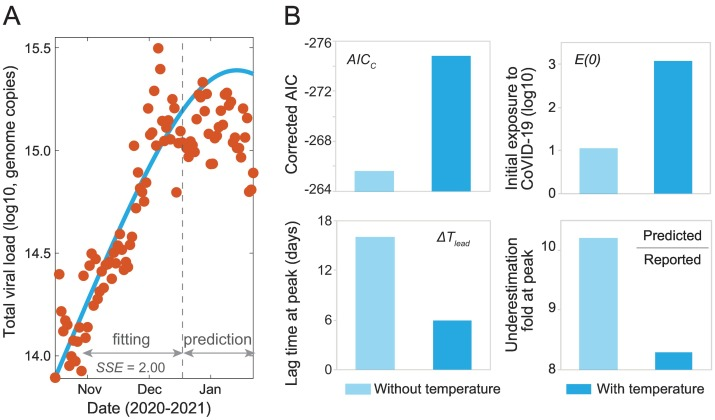

In [16]:
# TODO